In [1]:
import torch

c:\Users\chou0\miniconda3\envs\pytorch8019\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import pandas as pd
import torch
from torchvision import transforms
from PIL import Image
import os
from tqdm import tqdm
import cv2
import numpy as np
from torchvision import datasets, transforms

import torch.nn as nn
from torchvision import models
import torch.optim as optim
from torch.autograd import Variable


In [ ]:
ss = pd.read_csv("21ss.csv",encoding='utf-8')
print(ss.head())
print(ss.describe())

In [ ]:
aw = pd.read_csv("20aw.csv",encoding='utf-8')
print(aw.head())
print(aw.describe())

In [ ]:
aw = pd.read_table("20aw.csv",sep=',')
print(aw.head())
print(aw.describe())
print(aw.info())

In [ ]:
aw_ss = pd.concat([aw,ss],axis=0)
aw_ss = aw_ss.reset_index(drop=True)
aw_ss

In [ ]:
aw_ss.to_csv("all_sample.csv",encoding='utf-8')

In [ ]:
#把wrong變成no_fit 因為wrong也算是no_fit
all_sample=pd.read_csv("all_sample.csv",index_col=0)
all_sample['ans'] = all_sample['ans'].str.replace("wrong","not_fit")
all_sample

In [ ]:
#fit 7015,no_fit 2181, wrong 804
#all_sample=pd.read_csv("all_sample.csv")

negative_data=all_sample[all_sample["ans"]=="not_fit"]
postive_data=all_sample[all_sample["ans"]=="fit"]


#訓練2500 測試500
train_P=postive_data.sample(3000,random_state=178)
train_N=negative_data.sample(2985,random_state=198)
test_P=train_P.sample(500,random_state=73)
test_N=train_N.sample(485,random_state=65)

train_P=train_P.drop(test_P.index)
train_N=train_N.drop(test_N.index)
#source上身代碼#下身代碼
train_P=train_P.sort_values(by=["head_label","tail_label"]).reset_index(drop=True)
train_N=train_N.sort_values(by=["head_label","tail_label"]).reset_index(drop=True)
test_P=test_P.sort_values(by=["head_label","tail_label"]).reset_index(drop=True)
test_N=test_N.sort_values(by=["head_label","tail_label"]).reset_index(drop=True)

In [ ]:
#transform可以旋轉 縮放
transform=transforms.Compose([
    transforms.Resize(224), #缩放图片，保持长宽比不变，最短边的长为224像素,
    transforms.CenterCrop([150,224]), #中心裁剪，从中间切出 150*224的图片
])


In [ ]:
#把秋冬跟春夏資料及底下的子資料夾所有圖片都放在一起(會有重複的圖片)
#順便把圖片名稱改成單純編號
os.mkdir("OB_imgs")
save_dir = "OB_imgs/"
aw_dir = os.listdir("20aw/fit")
ss_dir = os.listdir("21ss/fit")
aw_label = aw[['head_label','tail_label']]
ss_label = ss[['head_label','tail_label']]
t_rec = []
b_rec = []

for i,fit in enumerate(tqdm(aw_dir)):
    path = "20aw/fit/" + fit
    fit_list = os.listdir(path)
    t = aw_label.iloc[i][0]
    b = aw_label.iloc[i][1]
    if fit_list[0].startswith(t):
        if t not in t_rec:
            os.rename(f'{path}/{fit_list[0]}',f'{save_dir}/{t}.png')
            t_rec.append(t)
        if b not in b_rec:
            os.rename(f'{path}/{fit_list[1]}',f'{save_dir}/{b}.png')
            b_rec.append(b)
    elif fit_list[0].startswith(b):
        if b not in b_rec:
            os.rename(f'{path}/{fit_list[0]}',f'{save_dir}/{b}.png')
            b_rec.append(b)
        if t not in t_rec:
            os.rename(f'{path}/{fit_list[1]}',f'{save_dir}/{t}.png')
            t_rec.append(t)
    
for j,fit in enumerate(tqdm(ss_dir)):
    path = "21ss/fit/" + fit
    fit_list = os.listdir(path)
    t = ss_label.iloc[j][0]
    b = ss_label.iloc[j][1]
    if fit_list[0].startswith(t):
        if t not in t_rec:
            os.rename(f'{path}/{fit_list[0]}',f'{save_dir}/{t}.png')
            t_rec.append(t)
        if b not in b_rec:
            os.rename(f'{path}/{fit_list[1]}',f'{save_dir}/{b}.png')
            b_rec.append(b)
    elif fit_list[0].startswith(b):
        if b not in b_rec:
            os.rename(f'{path}/{fit_list[0]}',f'{save_dir}/{b}.png')
            b_rec.append(b)
        if t not in t_rec:
            os.rename(f'{path}/{fit_list[1]}',f'{save_dir}/{t}.png')
            t_rec.append(t)
    
    
    

In [ ]:
imgs=os.listdir("OB_imgs")#回傳該路徑下有哪些檔案
pbar=tqdm(total=len(imgs))
for img in imgs:
    path="OB_imgs/"+img
    pil_img=Image.open(path)
    ttt=transform(pil_img)
    save_dir="crop_img_test/"+img
    ttt.save(save_dir)
    pbar.update(1)

pbar.close()
    

In [ ]:
def v_merge_img(data_df):
    source=list(data_df["head_label"])
    target=list(data_df["tail_label"])
    type=list(data_df["ans"])[0]
    if(len(data_df)==2500 and type=="fit"):
        folder_name="train/fit"
    elif(len(data_df)==2500 and type=="not_fit"):
        folder_name="train/not_fit"
    elif(len(data_df)==500 and type=="fit"):
        folder_name="test/fit"
    elif(len(data_df)==485 and type=="not_fit"):
        folder_name="test/not_fit"

    if (os.path.exists(folder_name)==False):
        os.mkdir(folder_name)

    for i,top in enumerate(source):
        top_dir="crop_img_test/"+top+".png"
        bottom_dir="crop_img_test/"+target[i]+".png"
        #用opencv讀取圖片
        top_img = cv2.imread(top_dir)
        bottom_img = cv2.imread(bottom_dir)
        fit_img = np.vstack([top_img, bottom_img])  # 垂直拼接，變成上下兩個組圖

        fit_img_dir=folder_name+"/fit"+str(i)+".png"
        cv2.imwrite(fit_img_dir,fit_img)
        
   


In [ ]:
v_merge_img(test_P)
v_merge_img(test_N)

v_merge_img(train_P)
v_merge_img(train_N)


In [4]:
transform2=transforms.Compose([#compose可以把調整方法串接起來
    transforms.Resize([224,224]), #缩放图片，保持长宽比不变，最短边的长为224像素, VGG的輸入規定格式
    transforms.ToTensor(), #將圖片或是ndarray轉換成Tensor,除255歸一化至[0,1]
    transforms.Normalize(mean=[.5,.5,.5],std=[.5,.5,.5]) #標準化至[-1,1]其實並非到0~1之間，模型才容易收斂 mean變成0 std變成1
])

batch_size=16 #原本16，建議設2的n次方，較有效率

train_dir = "train"           
#定義數據集
train_datasets = datasets.ImageFolder(train_dir, transform=transform2)
#加載數據集
train_dataloader = torch.utils.data.DataLoader(train_datasets, batch_size=batch_size, shuffle=True)

val_dir = "test"		
val_datasets = datasets.ImageFolder(val_dir, transform=transform2)
val_dataloader = torch.utils.data.DataLoader(val_datasets, batch_size=batch_size, shuffle=False)

In [5]:
class VGGNet(nn.Module):
    def __init__(self, num_classes=2):
        super(VGGNet, self).__init__()
        net = models.vgg16(pretrained=False)
        net.classifier = nn.Sequential()
        self.features = net
        self.classifier = nn.Sequential(
                nn.Linear(512 * 7 * 7, 512),
                nn.ReLU(True),
                nn.Dropout(),
                nn.Linear(512, 128),
                nn.ReLU(True),
                nn.Dropout(),
                nn.Linear(128, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [ ]:
#釋放無用的內存
#if hasattr(torch.cuda,'empty_cache'):
#torch.cuda.empty_cache()

In [7]:
learning_rate = 5e-5#5的負5次方
epoch = 15#如果overfitting的話，可以找train跟test都在高峰的epoch，就不要那麼多次epoch

model = VGGNet()
if torch.cuda.is_available():
    model.cuda()
params = [{'params': md.parameters()} for md in model.children()
          if md in [model.classifier]]
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_func = nn.CrossEntropyLoss()

model.train()

loss_list = []
accuracy_list = []
tr_loss_list = []
tr_accuracy_list = []

for i in range(epoch):
    print('epoch {}'.format(i + 1))
    train_loss = 0.
    train_acc = 0.
    pbar=tqdm(total=len(train_dataloader))
    for img, label in train_dataloader:
        img = Variable(img).cuda()
        label = Variable(label).cuda()
        optimizer.zero_grad()
        output = model(img)
        loss = loss_func(output, label)
        train_loss += loss.item()
        pred = torch.max(output, 1)[1]
        train_correct = (pred == label).sum()
        train_acc += train_correct.item()
        loss.backward()
        optimizer.step()
        pbar.update(1)
    pbar.close()

    print('Train Loss: {:.6f}, Acc: {:.6f}'.format(train_loss / (len(train_datasets)), train_acc / (len(train_datasets))))
    tr_loss_list.append(train_loss / (len(train_datasets)))
    tr_accuracy_list.append(100 * train_acc / (len(train_datasets)))

    # evaluation--------------------------------
    model.eval()
    eval_loss = 0.
    eval_acc = 0.
    for img, label in val_dataloader:
        img = Variable(img).cuda()
        label = Variable(label).cuda()
        out = model(img)
        loss = loss_func(out, label)
        eval_loss += loss.item()
        pred = torch.max(out, 1)[1]
        num_correct = (pred == label).sum()
        eval_acc += num_correct.item()
    print('Test Loss: {:.6f}, Acc: {:.6f}'.format(eval_loss / (len(val_datasets)), eval_acc / (len(val_datasets))))
    loss_list.append(eval_loss / (len(val_datasets)))
    accuracy_list.append(100 * eval_acc / (len(val_datasets)))

epoch 1


100%|██████████| 313/313 [01:00<00:00,  5.19it/s]


Train Loss: 0.043466, Acc: 0.502400
Test Loss: 0.043670, Acc: 0.492386
epoch 2


100%|██████████| 313/313 [01:00<00:00,  5.19it/s]


Train Loss: 0.043345, Acc: 0.514200
Test Loss: 0.043457, Acc: 0.562437
epoch 3


100%|██████████| 313/313 [01:00<00:00,  5.20it/s]


Train Loss: 0.042923, Acc: 0.553800
Test Loss: 0.042589, Acc: 0.579695
epoch 4


100%|██████████| 313/313 [00:59<00:00,  5.22it/s]


Train Loss: 0.042133, Acc: 0.585200
Test Loss: 0.043129, Acc: 0.531980
epoch 5


100%|██████████| 313/313 [00:59<00:00,  5.22it/s]


Train Loss: 0.040570, Acc: 0.620600
Test Loss: 0.039972, Acc: 0.648731
epoch 6


100%|██████████| 313/313 [01:00<00:00,  5.21it/s]


Train Loss: 0.038113, Acc: 0.664600
Test Loss: 0.038763, Acc: 0.668020
epoch 7


100%|██████████| 313/313 [01:00<00:00,  5.19it/s]


Train Loss: 0.034792, Acc: 0.716200
Test Loss: 0.035888, Acc: 0.702538
epoch 8


100%|██████████| 313/313 [01:00<00:00,  5.19it/s]


Train Loss: 0.030429, Acc: 0.770600
Test Loss: 0.033480, Acc: 0.726904
epoch 9


100%|██████████| 313/313 [01:00<00:00,  5.19it/s]


Train Loss: 0.026701, Acc: 0.803200
Test Loss: 0.034162, Acc: 0.759391
epoch 10


100%|██████████| 313/313 [01:00<00:00,  5.19it/s]


Train Loss: 0.022171, Acc: 0.844400
Test Loss: 0.034115, Acc: 0.752284
epoch 11


100%|██████████| 313/313 [01:00<00:00,  5.19it/s]


Train Loss: 0.018376, Acc: 0.874400
Test Loss: 0.034484, Acc: 0.735025
epoch 12


100%|██████████| 313/313 [01:00<00:00,  5.19it/s]


Train Loss: 0.014374, Acc: 0.904600
Test Loss: 0.034903, Acc: 0.775635
epoch 13


100%|██████████| 313/313 [01:00<00:00,  5.19it/s]


Train Loss: 0.010727, Acc: 0.930000
Test Loss: 0.042477, Acc: 0.770558
epoch 14


100%|██████████| 313/313 [01:00<00:00,  5.19it/s]


Train Loss: 0.007930, Acc: 0.952200
Test Loss: 0.048243, Acc: 0.770558
epoch 15


100%|██████████| 313/313 [01:00<00:00,  5.19it/s]


Train Loss: 0.006597, Acc: 0.962800
Test Loss: 0.050028, Acc: 0.786802


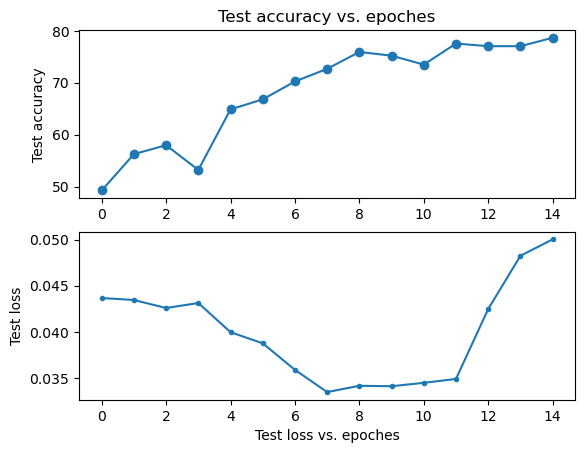

In [11]:
import matplotlib.pyplot as plt

x1 = range(0, 15)
x2 = range(0, 15)
y1 = accuracy_list
y2 = loss_list
plt.subplot(2, 1, 1)
plt.plot(x1, y1, 'o-')
plt.title('Test accuracy vs. epoches')
plt.ylabel('Test accuracy')
plt.subplot(2, 1, 2)
plt.plot(x2, y2, '.-')
plt.xlabel('Test loss vs. epoches')
plt.ylabel('Test loss')
plt.show()
# plt.savefig("accuracy_loss.jpg")


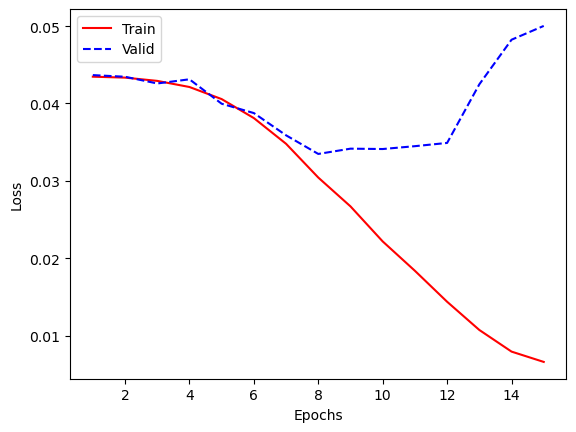

In [12]:
#distplot
import matplotlib.pyplot as plt
epochs =[i+1 for i in range(15)]
plt.plot(epochs,tr_loss_list, color='red', label='Train')
plt.plot(epochs,loss_list, '--', color='blue', label='Valid')
#plt.title('CrossEntropy') # title
plt.ylabel("Loss") # y label
plt.xlabel("Epochs") # x label
plt.legend() #圖例
#plt.savefig('.\\Model\\0618\\t_model_' + str(isbalence) + 'bz' + str(batch_sizes) + '_' + str(num_epochs) + '.png') #儲存圖檔
#plt.savefig('.\\Model\\0618\\實驗' + str(testnum) + '.png') #儲存圖檔
plt.show()

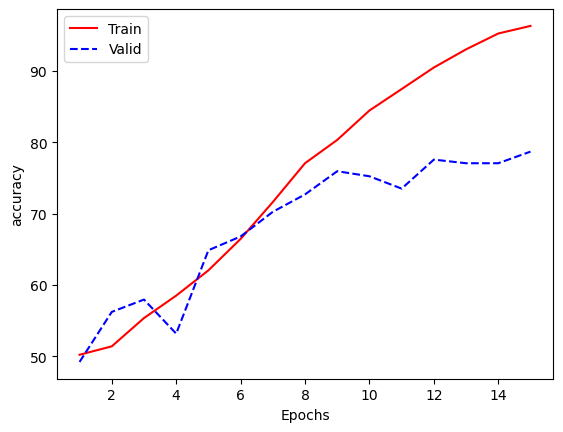

In [13]:
#distplot
import matplotlib.pyplot as plt
epochs =[i+1 for i in range(15)]
plt.plot(epochs,tr_accuracy_list, color='red', label='Train')
plt.plot(epochs,accuracy_list, '--', color='blue', label='Valid')
#plt.title('CrossEntropy') # title
plt.ylabel("accuracy") # y label
plt.xlabel("Epochs") # x label
plt.legend() #圖例
#plt.savefig('.\\Model\\0618\\t_model_' + str(isbalence) + 'bz' + str(batch_sizes) + '_' + str(num_epochs) + '.png') #儲存圖檔
#plt.savefig('.\\Model\\0618\\實驗' + str(testnum) + '.png') #儲存圖檔
plt.show()

In [14]:
torch.save(model.state_dict(), "VGG16_96_78.pt")


In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)